# Entrainer les agents addi

## Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%reset -f

In [3]:
%cd /content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/

/content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler


In [4]:
#ou bien 
#!cp -r drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/* .

In [5]:
import Euler.core_solver as core
import Euler.agent_addi as aga
import Euler.neural_networks as nn

from Euler.backend import K
from Euler.param import Param,Projecter
from Euler.initial_conditions import *

#from Euler.backend import K
import matplotlib.pyplot as plt
import popup_lib.popup as pop
import numpy as np
import copy
import time

Popup loaded!


In [6]:
param = Param(nx=1000,nx_ratio=10,
              BC_solver=Param.BC_periodic,
              BC_model=Param.BC_periodic)
k_tf32=K("tf",32)

Param initialised with, nx=1000, nx_coarse=99


## Génération des données

In [7]:
def show_w_init(W):
    fig,axs=plt.subplots(3,3,sharex="all",sharey="all",figsize=(6,6))
    axs=axs.flatten()

    for i in range(9):
        axs[i].plot(W[i,:,0],label=r"$\rho$")
        axs[i].plot(W[i,:,1],label=r"$\rho V$")
        axs[i].plot(W[i,:,2],label="$E$")
    plt.legend()
    plt.show()

In [8]:
genParam=GenParam(param,GenParam.kind_changing)

#paramètres commun à toutes les conditions initiales
genParam.same_discontinuities=True
genParam.initial_speed_factor=0.5

In [9]:
generator=FuncGenerator(genParam,param,k_tf32)

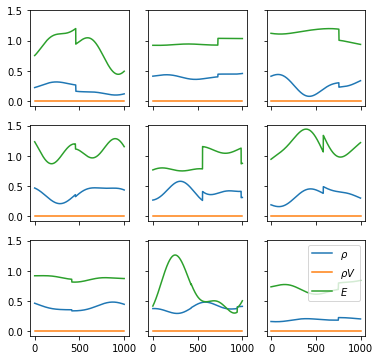

In [10]:
def type_A():
    genParam.batch_size = 150#60

    genParam.kind=GenParam.kind_changing
    genParam.changing_discountMinSpacing= 0.4
    genParam.changing_discountMaxSpacing= 0.8

    genParam.continuousPart_scale = 0.2
    genParam.discontinuousPart_scale =0.2
    return generator.init_W()

show_w_init(type_A())

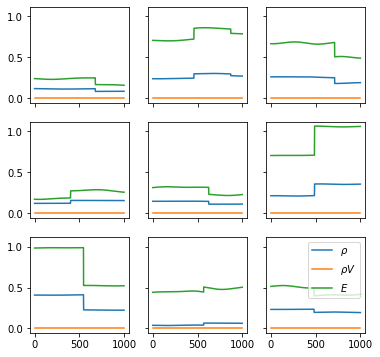

In [11]:
def type_B():
    genParam.batch_size = 50
    genParam.kind=GenParam.kind_changing

    genParam.changing_discountMinSpacing= 0.4
    genParam.changing_discountMaxSpacing= 0.8

    genParam.continuousPart_scale = 0.01
    genParam.discontinuousPart_scale =0.3
    return generator.init_W()

show_w_init(type_B())

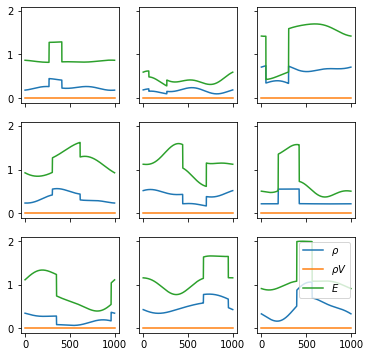

In [12]:
def type_C():
    genParam.kind=GenParam.kind_loop
    genParam.batch_size = 100

    genParam.continuousPart_scale = 0.2
    genParam.discontinuousPart_scale =0.2
    return generator.init_W()

show_w_init(type_C())

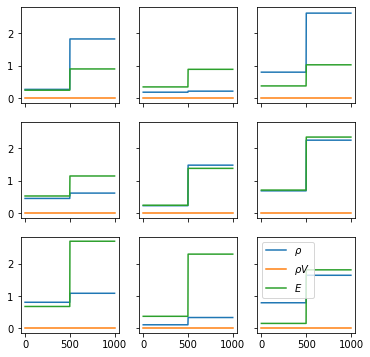

In [13]:
#attention, si les random sod vont trop proche de zéro => ça pète
def type_D():
    return init_random_sod(param, batch_size=50, k=k_tf32, minimum_E=0.05, maximal_jump_E=2, minimum_rho=0.05, maximal_jump_rho=2)

show_w_init(type_D())

In [14]:
#attention, il faut mettre des jeux d'entrainement assez gros pour 
#limiter le hasard du sampling
#Quand, au bout d'une longue stagnation, tous les agents s'améliore d'un coup, c'est suspect ! 
def all_type():
    #return k_tf32.concatenate([type_A(),type_B(),type_C(),type_D()],axis=0)
    return type_A()

w_init=all_type()
w_init.shape

TensorShape([100, 1000, 3])

In [15]:
nb_t=1000
def generate_fine_solutions():
    w_init=all_type()

    #BC_periodic rajoute une discontinuité au bord pour chaque fonction non périodique
    param.BC_model=param.BC_solver=Param.BC_periodic
    return core.compute_solutions(param, nb_t, w_init,False, k_tf32)
W_val=generate_fine_solutions()
W_val.shape

TensorShape([1000, 100, 1000, 3])

## Entrainement

### Définition des familles d'agent

In [16]:
fam_size=6
#un durée pour que les agents puissent tous faire leur 'nb_optimization' optimizations
#attention, cela dépend beaucoup de la watch_duration
period_duration="6 steps"#"15 seconds" 
all_agents=[]

In [17]:
def family_full(window_size,color):
        name="full_"+str(window_size)
        agents=[]
        model_struct = (32,64,32)
        for _ in range(fam_size):
            model=nn.Difference_model_tricky(
                param,
                window_size,
                censure=False,
                model_struct=model_struct)
            
            model.toggle_tricky_kernel_trainable(False)
            
            agent= aga.Agent_addi(param, 
                            model,
                            watch_duration=50, #20
                            lossCoef_stab=100., #10.
                            lossCoef_ridge=3e-3,
                            lossCoef_disHLL=1.,
                            nb_optimization=15,
                            watch_duration_for_val=0.1 #si <1, c'est une proportion
                            )
            agents.append(agent)
            all_agents.append(agent)
            
        return pop.Family_trainer(
            agents=agents,
            nb_bestweights_averaged=3,
            nb_strong=3,
            period_duration=period_duration,
            name=name,
            color=color)

family_trainers=[
                 family_full(5,"red"),
                #  family_full(3,"blue"),
                 ]



In [18]:
def load_data():
    ti=time.time()
    W_train = generate_fine_solutions()
    W_val = generate_fine_solutions()
    print(f"|génération des données, durée: {time.time()-ti:.2f} ",end="")
    
    ti=time.time()
    for agent in all_agents:
        agent.load_WY_train(W_train)
        agent.load_WY_valid(W_val)
    print(f"|load données,durée: {time.time()-ti:.2f}",end="")

### LA BOUCLE

In [19]:
try:
    for i in range(50):
        load_data()
        for family_trainer in family_trainers:
            family_trainer.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()

|génération des données, durée: 1.16 traçage de la méthode _load_WY_accelerated
traçage de la méthode _load_WY_accelerated
traçage de la méthode _load_WY_accelerated
traçage de la méthode _load_WY_accelerated
traçage de la méthode _load_WY_accelerated
traçage de la méthode _load_WY_accelerated
|load données,durée: 3.46
full_5,échauffement Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': False
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': True
a↗1.0562Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': False
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': True
b↗1.041Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': False
traçage de la méthode _pr

### Historique des `famparams`

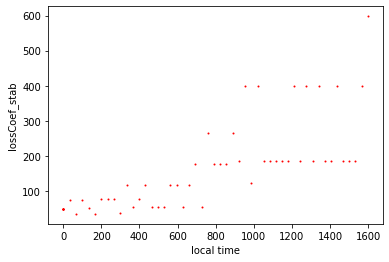

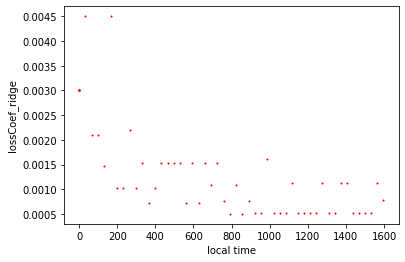

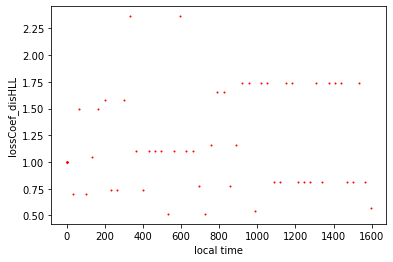

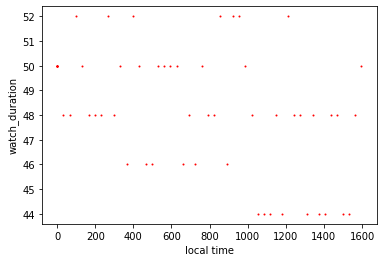

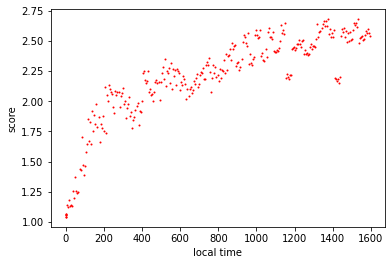

In [20]:
def plot_history_famparams():
    # keys=["lossCoef_stab","lossCoef_ridge","lossCoef_disHLL","lossCoef_Laplacian","watch_duration","score"]
    keys=["lossCoef_stab","lossCoef_ridge","lossCoef_disHLL","watch_duration","score"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_famparams()

### Historique des trois `loss`

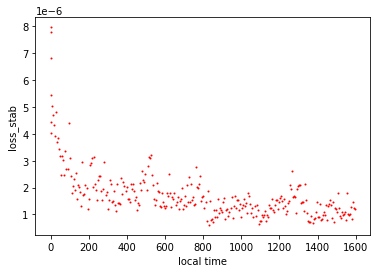

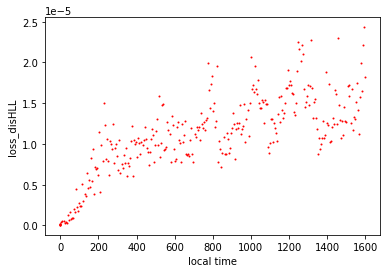

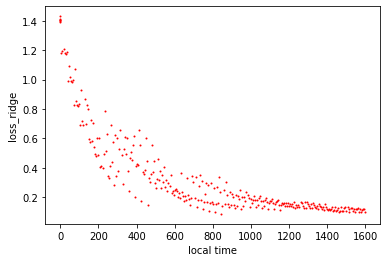

In [21]:
def plot_history_losses():
    # keys=["loss_stab","loss_disHLL","loss_ridge","loss_Laplacian"]
    keys=["loss_stab","loss_disHLL","loss_ridge"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_losses()

### Valeurs des famparams

In [22]:
import tensorflow as tf
family_trainer=family_trainers[0]

for name,agent_w in family_trainer.agents.items():
    print(name)
    print(agent_w.agent.famparams)
    print(agent_w.agent.agent_score())


best_agent=family_trainer.get_best_agent()
# best_agent=family_trainer.agents['a'].agent
print("best agent")
print(best_agent.famparams)
# print(best_agent.agent_score())


a
{'lossCoef_stab': 186.046875, 'lossCoef_ridge': 0.0005294204999999998, 'lossCoef_disHLL': 1.7364374999999996, 'watch_duration': 44}
2.5524356
b
{'lossCoef_stab': 265.78125, 'lossCoef_ridge': 0.0007563149999999998, 'lossCoef_disHLL': 1.1576249999999997, 'watch_duration': 46}
2.5860624
c
{'lossCoef_stab': 598.0078125, 'lossCoef_ridge': 0.0007941307499999997, 'lossCoef_disHLL': 0.5672362499999998, 'watch_duration': 50}
2.5929463
d
{'lossCoef_stab': 398.671875, 'lossCoef_ridge': 0.0005294204999999998, 'lossCoef_disHLL': 0.8103374999999997, 'watch_duration': 48}
2.6017876
e
{'lossCoef_stab': 398.671875, 'lossCoef_ridge': 0.0011344724999999998, 'lossCoef_disHLL': 0.8103374999999997, 'watch_duration': 48}
2.5634246
f
{'lossCoef_stab': 265.78125, 'lossCoef_ridge': 0.0007563149999999998, 'lossCoef_disHLL': 1.1576249999999997, 'watch_duration': 50}
2.5420043
best agent
{'lossCoef_stab': 265.78125, 'lossCoef_ridge': 0.0007563149999999998, 'lossCoef_disHLL': 1.1576249999999997, 'watch_duration':

## Testons le long du temps

In [23]:
def compare_along_the_time(W_val):
    nb_t = len(W_val)
    
    best_agent.load_WY_valid(W_val)
    res_fine_proj,res_HLL,res_model=best_agent.predict()
        
    nb_batch_plot=5
    if nb_batch_plot>W_val.shape[1]:
        nb_batch_plot=W_val.shape[1]
    
    nb_t_plot=6
    #pour avoir le permier temps et le dernier
    t_to_plot=np.floor(np.linspace(0,nb_t-1,nb_t_plot)).astype(int)
    fig, ax = plt.subplots(nb_t_plot,nb_batch_plot,figsize=(15,nb_t_plot*2))
    if nb_batch_plot==1:ax=ax[:,tf.newaxis]
    
    for i,t in enumerate(t_to_plot):
        for j in range(nb_batch_plot):
            ax[i,j].plot(res_fine_proj[t,j,:,0],color="k",label="fine")
            ax[i,j].plot(res_HLL[t,j,:,0],color="b",label="HLL")
            ax[i,j].plot(res_model[t,j,:,0],"r",label="model")
    ax[0,0].legend()    

    fig.tight_layout()
    
    errors_HLL=tf.reduce_mean(tf.abs(res_fine_proj-res_HLL),axis=[1,2,3])
    errors_model=tf.reduce_mean(tf.abs(res_fine_proj-res_model),axis=[1,2,3])
    
    fig,ax=plt.subplots()
    ax.plot(errors_HLL,label="HLL")
    ax.plot(errors_model,label="model")

    # if (np.max(errors_model)>0.1):
    #     ax.set_ylim(0,0.1)
    
    ax.legend()
    ax.set_xlabel("time")

    plt.show()

### kind Loop

In [24]:
genParam.kind=GenParam.kind_loop
generator=FuncGenerator(genParam,param,k_tf32)
w_init=generator.init_W()
w_init.shape

TensorShape([100, 1000, 3])

In [25]:
nb_t=1000
param.BC_model=param.BC_solver=Param.BC_periodic
W_val = core.compute_solutions(param, nb_t, w_init,False, k_tf32)
W_val.shape

TensorShape([1000, 100, 1000, 3])

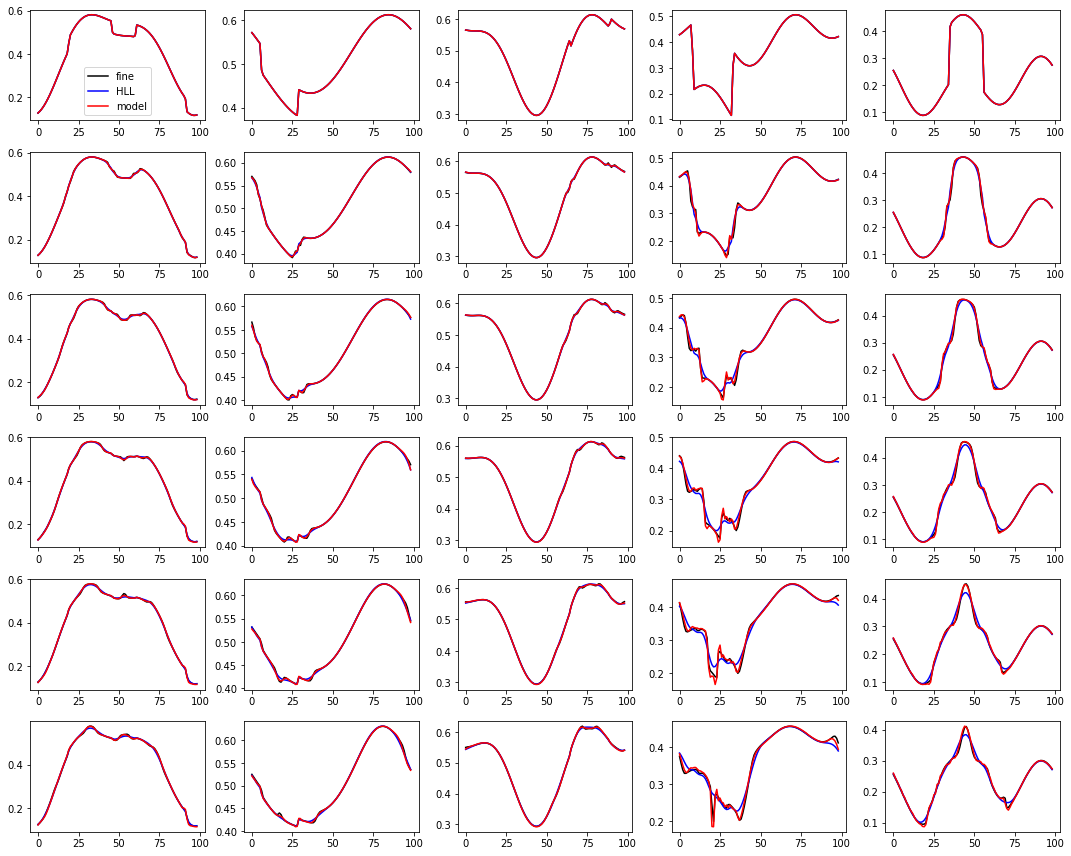

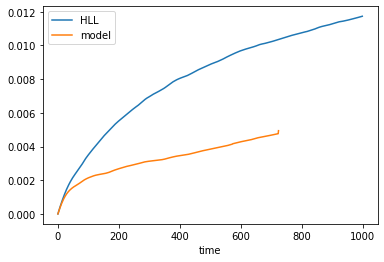

In [26]:
compare_along_the_time(W_val)

### kind changing

In [27]:
genParam.kind=GenParam.kind_changing
generator=FuncGenerator(genParam,param,k_tf32)
w_init=generator.init_W()
w_init.shape

TensorShape([100, 1000, 3])

In [28]:
nb_t=1000
param.BC_model=param.BC_solver=Param.BC_reflexive
W_val = core.compute_solutions(param, nb_t, w_init,False, k_tf32)
W_val.shape

TensorShape([1000, 100, 1000, 3])

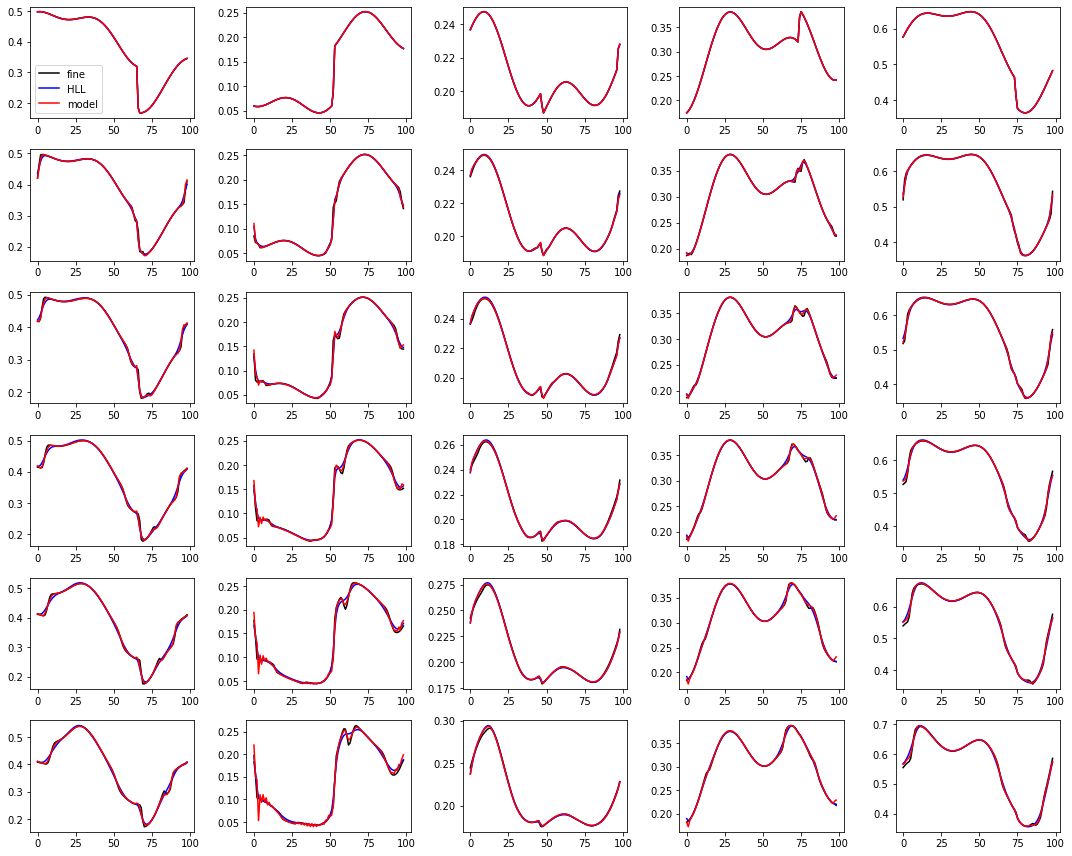

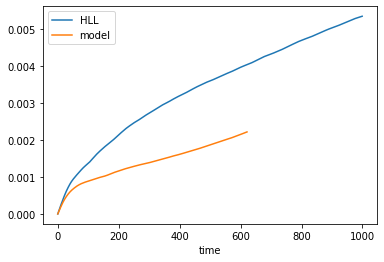

In [29]:
compare_along_the_time(W_val)

### kind Sod

In [30]:
def generate_Riemann_Problem(batch_size):
    k = k_tf32
    res = np.zeros([batch_size, param.nx])
    for i in range(batch_size):
        w_left = 0.5 + np.random.random()
        w_right = 0.5 + np.random.random()
        res[i, :param.nx // 2] = max(w_left, w_right)
        res[i, param.nx // 2:] = min(w_left, w_right)
    return k.convert(res)
A=generate_Riemann_Problem(5)
A.shape

TensorShape([5, 1000])

In [31]:
def deterministic_SOD(batch_size):
    k=k_tf32
    x = k.arange_float(param.xmin, param.xmax, param.dx)
            
    #La densité peu être assez faible: 0.1 OK, 0.01-> quelques oscilations
    rho_0 =  k.where_float(x < 0.5, 1., 0.5 ) #0.125
    #Par contre la pression ne doit pas proche de zéro: avec 0.01 cela craque tout de suite
    P_0 =    k.where_float(x < 0.5, 1., 0.5)   #0.1

    P_coefs=np.linspace(1,10,batch_size)

    rho=[rho_0 for _ in range(batch_size)]
    #rho=[rho_0*coef for coef in P_coefs]
    P=[P_0*coef for coef in P_coefs]
    rhoV = k.zeros_float([batch_size, param.nx])

    return np.stack([rho,rhoV,P],axis=2)

In [32]:
#w_init=random_SOD(5)
w_init=deterministic_SOD(5)

nb_t=1000
param.BC_model=param.BC_solver=param.BC_neumann
W_val = core.compute_solutions(param, nb_t, w_init,False, k_tf32)
W_val.shape

TensorShape([2000, 5, 1000, 3])

traçage de la méthode _load_WY_accelerated
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': True
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': False


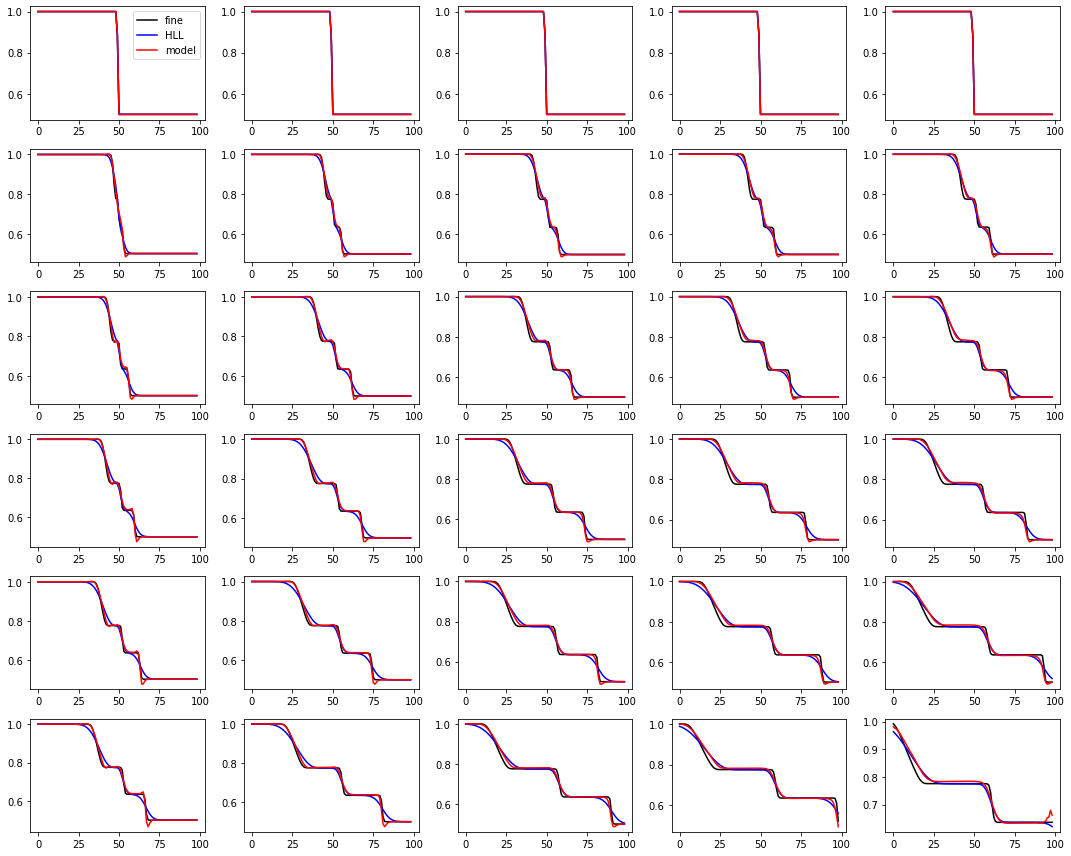

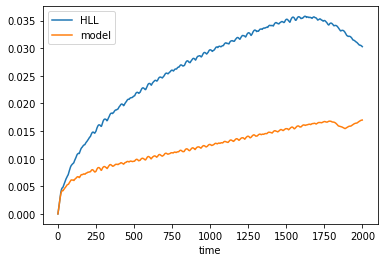

In [33]:
compare_along_the_time(W_val)

### Kind random Sod

In [34]:
w_init=init_random_sod(param, batch_size=50, k=k_tf32, minimum_E=0.05, maximal_jump_E=2, minimum_rho=0.05, maximal_jump_rho=2)
w_init.shape

TensorShape([50, 1000, 3])

In [35]:
nb_t=1000
param.BC_model=param.BC_solver=Param.BC_neumann
W_val = core.compute_solutions(param, nb_t, w_init,False, k_tf32)
W_val.shape

TensorShape([1000, 50, 1000, 3])

traçage de la méthode _load_WY_accelerated
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': True
traçage de la méthode _predict_accelerated, pour l'estimation 'is_model?': False


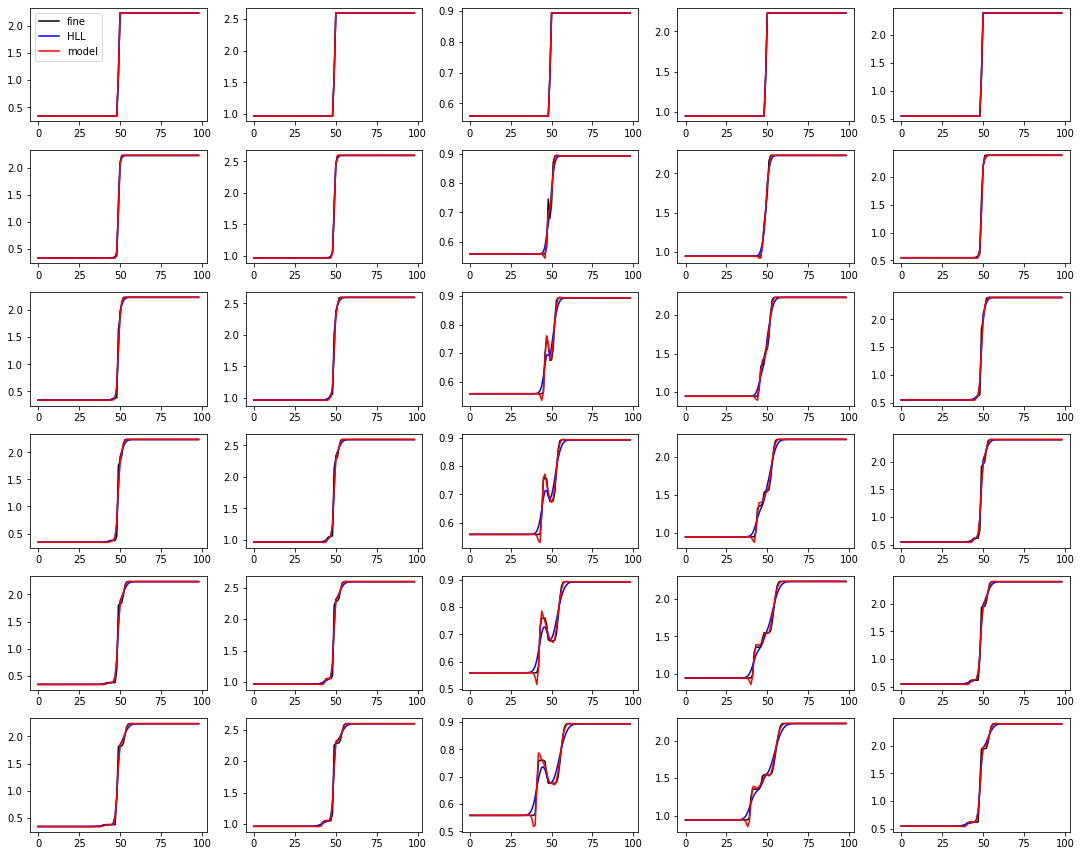

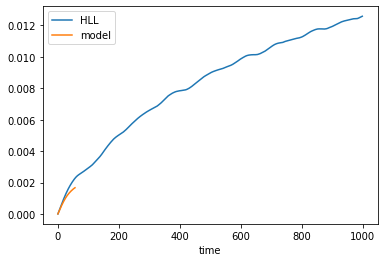

In [36]:
compare_along_the_time(W_val)